In [40]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import tree
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import BaggingClassifier,BaggingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve


## data preparation

In [41]:
# load the data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
# set sort=False because test data don't have survived data
combine = pd.concat([train,test],sort=False)

### feature engineering

In [42]:
# Name length
combine['Name_len'] = combine['Name'].apply(lambda x:len(x))
combine['Name_len'] = pd.qcut(combine['Name_len'],5)

In [43]:
combine['Title'] = combine['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
combine.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [44]:
# Title from Name
combine['Title'] = combine['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
combine['Title'] = combine['Title'].replace(['Master','Major','Col','Sir','Dr', 'Col'],'Royalty')
combine['Title'] = combine['Title'].replace(['Rev','Don','Capt','Jonkheer'],'Goodman')
combine['Title'] = combine['Title'].replace(['Mlle','Ms','Dona'], 'Miss')
combine['Title'] = combine['Title'].replace(['the Countess','Mme','Lady'], 'Mrs')
df = pd.get_dummies(combine['Title'],prefix='Title')
combine = pd.concat([combine,df],axis=1)

In [45]:
# Family and family name
combine['Fname'] = combine['Name'].apply(lambda x:x.split(',')[0])
combine['Familysize'] = combine['SibSp'] + combine['Parch']
dead_female_Fname = list(set(combine[(combine.Sex=='female') & (combine.Age>=12)
                              & (combine.Survived==0) & (combine.Familysize>1)]['Fname'].values))
survive_male_Fname = list(set(combine[(combine.Sex=='male') & (combine.Age>=12)
                              & (combine.Survived==1) & (combine.Familysize>1)]['Fname'].values))
combine['Dead_female_family'] = np.where(combine['Fname'].isin(dead_female_Fname),1,0)
combine['Survive_male_family'] = np.where(combine['Fname'].isin(survive_male_Fname),1,0)
combine = combine.drop(['Name','Fname'],axis=1)

In [46]:
# Age
# discretize age, add new feature 'IsChild'
group = combine.groupby(['Title', 'Pclass'])['Age']
combine['Age'] = group.transform(lambda x: x.fillna(x.median()))
combine = combine.drop('Title',axis=1)
combine['IsChild'] = np.where(combine['Age']<=12,1,0)
combine['Age'] = pd.cut(combine['Age'],5)
# combine = combine.drop('Age',axis=1)


In [47]:
# one-hot encoding 'Familysize'
combine['Familysize'] = np.where(combine['Familysize']==0, 'solo',
                                    np.where(combine['Familysize']<=3, 'normal', 'big'))
df = pd.get_dummies(combine['Familysize'],prefix='Familysize')
combine = pd.concat([combine,df],axis=1).drop(['SibSp','Parch','Familysize'],axis=1)

In [48]:
# Cabin
combine['Cabin_isNull'] = np.where(combine['Cabin'].isnull(),0,1)
combine = combine.drop('Cabin',axis=1)

In [49]:
# Embarked, fill NaN with S
# because there is only two NaN, it will not help a lot to set NaN as a category 
combine.Embarked = combine.Embarked.fillna('C')
df = pd.get_dummies(combine['Embarked'],prefix='Embarked')
combine = pd.concat([combine,df],axis=1).drop('Embarked',axis=1)

In [50]:
# Pclass, one hot encoding
df = pd.get_dummies(combine['Pclass'],prefix='Pclass')
combine = pd.concat([combine,df],axis=1).drop('Pclass',axis=1)

In [51]:
# Sex
df = pd.get_dummies(combine['Sex'],prefix='Sex')
combine = pd.concat([combine,df],axis=1).drop('Sex',axis=1)

In [52]:
# Fare
combine['Fare'] = pd.qcut(combine.Fare,10)
df = pd.get_dummies(combine.Fare,prefix='Fare')
combine = pd.concat([combine,df],axis=1).drop('Fare',axis=1)

In [53]:
# ticket
combine['Ticket_Lett'] = combine['Ticket'].apply(lambda x: str(x)[0])
combine['Ticket_Lett'] = combine['Ticket_Lett'].apply(lambda x: str(x))

combine['High_Survival_Ticket'] = np.where(combine['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
combine['Low_Survival_Ticket'] = np.where(combine['Ticket_Lett'].isin(['A','W','3','7']),1,0)
combine = combine.drop(['Ticket','Ticket_Lett'],axis=1)

In [54]:
features = combine.drop(["PassengerId","Survived"], axis=1).columns
le = preprocessing.LabelEncoder()
for feature in features:
    le = le.fit(combine[feature])
    combine[feature] = le.transform(combine[feature])

In [55]:
combine.rename(columns={
    "Fare_(-0.001, 7.568]":"Fare_0",
    "Fare_(7.568, 7.854]":"Fare_1",
    "Fare_(7.854, 8.05]":"Fare_2",
    "Fare_(8.05, 10.5]":"Fare_3",
    "Fare_(10.5, 14.454]":"Fare_4",
    "Fare_(14.454, 21.679]":"Fare_5",
    "Fare_(21.679, 26.955]":"Fare_6",
    "Fare_(26.955, 41.579]":"Fare_7",
    "Fare_(41.579, 78.051]":"Fare_8",
    "Fare_(78.051, 512.329]":"Fare_9"
},inplace=True)

In [56]:
combine

,PassengerId,Survived,Age,Name_len,Title_Goodman,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty,Dead_female_family,...,Fare_2,Fare_3,Fare_4,Fare_5,Fare_6,Fare_7,Fare_8,Fare_9,High_Survival_Ticket,Low_Survival_Ticket
0,1,0.0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,2,4,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,3,1.0,1,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,1.0,2,4,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
4,5,0.0,2,2,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,6,0.0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6,7,0.0,3,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,8,0.0,0,3,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
8,9,1.0,1,4,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
9,10,1.0,0,4,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [57]:
X_all = combine.iloc[:891,:].drop(["PassengerId","Survived"], axis=1)
Y_all = combine.iloc[:891,:]["Survived"]
X_test = combine.iloc[891:,:].drop(["PassengerId","Survived"], axis=1)

## build model and train

In [58]:
combine.columns

Index(['PassengerId', 'Survived', 'Age', 'Name_len', 'Title_Goodman',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Royalty',
       'Dead_female_family', 'Survive_male_family', 'IsChild',
       'Familysize_big', 'Familysize_normal', 'Familysize_solo',
       'Cabin_isNull', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Fare_0', 'Fare_1',
       'Fare_2', 'Fare_3', 'Fare_4', 'Fare_5', 'Fare_6', 'Fare_7', 'Fare_8',
       'Fare_9', 'High_Survival_Ticket', 'Low_Survival_Ticket'],
      dtype='object')

In [59]:
import xgboost as xgb
from xgboost import XGBClassifier

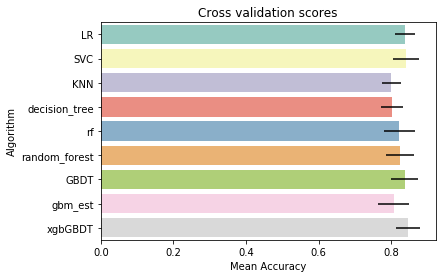

In [63]:
lr = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
dt = DecisionTreeClassifier()
rf0 = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
rf = RandomForestClassifier(n_estimators = 750, criterion = 'gini', max_features = 'sqrt',
                                             max_depth = 3, min_samples_split = 4, min_samples_leaf = 2,
                                             n_jobs = 50, random_state = 42, verbose = 1)
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
gbm_est = GradientBoostingClassifier(n_estimators=900, learning_rate=0.0008, loss='exponential',
                                                  min_samples_split=3, min_samples_leaf=2, max_features='sqrt',
                                                  max_depth=3, random_state=42, verbose=1)
xgbGBDT = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clfs = [lr, svc, knn, dt, rf0, rf, gbdt, gbm_est, xgbGBDT]



kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, X_all, y = Y_all, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LR","SVC",'KNN','decision_tree',"rf","random_forest","GBDT","gbm_est","xgbGBDT"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [64]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.838385,0.027085,LR
1,0.840596,0.035217,SVC
2,0.800270,0.025540,KNN
3,0.802530,0.030623,decision_tree
4,0.821682,0.042687,rf
5,0.824839,0.038641,random_forest
6,0.836151,0.036924,GBDT
7,0.805976,0.042174,gbm_est
8,0.845127,0.032811,xgbGBDT


### model ensemble

In [65]:
class Ensemble(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        return s

## prediction

In [67]:
bag = Ensemble([('gbdt',gbdt),('xgbGBDT',xgbGBDT),('rf',rf),('svc',svc),('lr',lr)])
bag.fit(X_all, Y_all)
predictions = bag.predict(X_test)

[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.4s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.8s finished
E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.3s finished
E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)

In [68]:
submission = pd.DataFrame({
    'PassengerId': test["PassengerId"],
    'Survived': predictions.astype(np.int32)
})
submission.to_csv('./v3.csv',mode='w+',index=False)

In [ ]:
# only use gbdt model
# the submission result is the same as using the ensemble model, why?
xgbGBDT.fit(X_all,Y_all)
predictions = gbdt.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test["PassengerId"],
    'Survived': predictions.astype(np.int32)
})
submission.to_csv('./v3_xgb.csv',mode='w+',index=False)